In [1]:
from PIL import Image
import numpy as np
import os, sys
from pathlib import Path
root_path = Path.cwd().parents[1]
if str(root_path) not in sys.path:
  sys.path.append(str(root_path))
print(f"{root_path=}")

root_path=PosixPath('/home/yy/Coding/GitHub/KataCR')


In [2]:
from katacr.detection.parser import get_args_and_writer
from katacr.detection.model import get_state
from katacr.utils.model_weights import load_weights

args = get_args_and_writer(no_writer=True, input_args="")
args.model_name = "YOLOv5"
args.path_logs = root_path / "logs"
path_debug = args.path_logs / "debug"
args.path_cp = args.path_logs / "YOLOv5-checkpoints"
args.load_id = 100
state_ok = load_weights(get_state(args, use_init=False), args)
# args.load_id = 70
# state_bad = load_weights(get_state(args, use_init=False), args)

Successfully load weights from '/home/yy/Coding/GitHub/KataCR/logs/YOLOv5-checkpoints/YOLOv5-0100'


In [3]:
%load_ext autoreload
%autoreload 2
# from katacr.detection.predict import Predictor
from katacr.detection.predict import Predictor
from katacr.utils.detection.data import show_box
predict_ok = Predictor(args, state_ok)
# predict_bad = Predictor(args, state_bad)

In [14]:
# img = []
# for p in Path("/home/wty/Pictures/model_test/test_image/8examples").glob('*.jpg'):
#   img.append(np.array(Image.open(str(p)).resize((640,640)).convert("RGB")))
# img = np.array(img)
# print(f"{len(img)=}, {img.dtype=}")
# for i in range(len(img)):
#   x = img[i:i+1].astype(np.float32) / 255.
#   pbox = predict_bad.update(x, nms_iou=0.65, nms_conf=0.01)
#   show_box(x[0], pbox[0])

In [4]:
from katacr.detection.dataset_builder import DatasetBuilder
args.batch_size = 1
ds_builder = DatasetBuilder(args)
train_ds = ds_builder.get_dataset(subset='train')
val_ds = ds_builder.get_dataset(subset='val')
iter_ds = iter(train_ds)
# iter_ds = iter(val_ds)

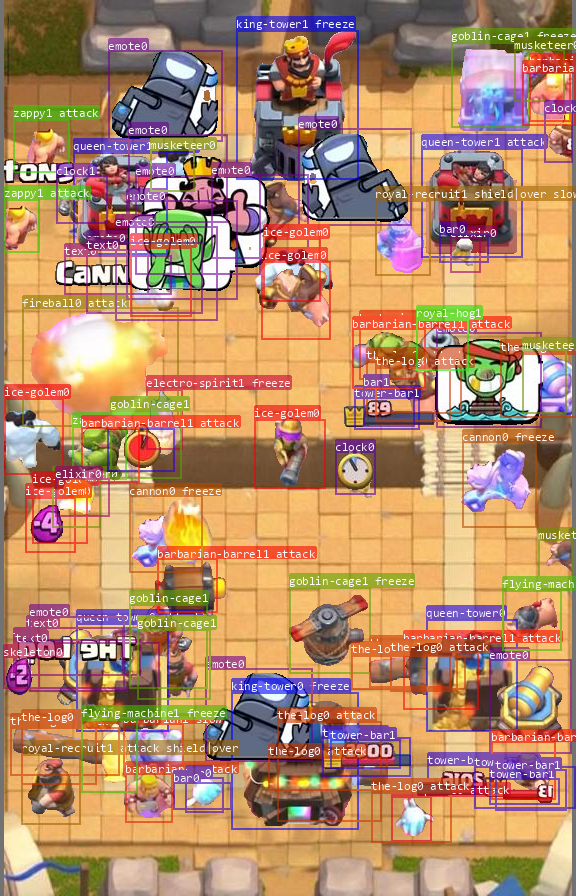


(eog:57545): EOG-WARNING **: 11:42:33.877: Couldn't load icon: Icon 'image-loading' not present in theme candy-icons


In [6]:
x, tbox, tnum = next(iter_ds)
x, tbox, tnum = x.numpy().astype(np.float32) / 255., tbox.numpy(), tnum.numpy()
pbox = predict_ok.update(x, nms_conf=0.1, nms_iou=0.65)
show_box(x[0], pbox[0], use_overlay=True)
# pbox = predict_bad.update(x, nms_conf=0.5, nms_iou=0.65)
# show_box(x[0], pbox[0], use_overlay=True)

In [ ]:
pbox = predict_bad.update(x, nms_conf=0.01)
show_box(x[0], pbox[0])

In [ ]:
# Save current data
Image.fromarray((x[0]*255).astype(np.uint8)).save(path_debug / "origin.jpg")
with (path_debug / "sample_data.npy").open('wb') as file:
  np.save(
    file, {
      'x': x,
      'tbox': tbox,
      'tnum': tnum
    }, allow_pickle=True
  )

In [ ]:
print("tbox number:", tnum[0])
show_box(x[0], tbox[0][:tnum[0]])

In [ ]:
from katacr.detection.loss import ComputeLoss
compute_loss = ComputeLoss(args)

In [ ]:
_, metrics = compute_loss.step(state_ok, x, tbox, tnum)
for val, name in zip(metrics, ['loss', 'lbox', 'lobj', 'lcls', 'l2']):
  if name not in ['loss', 'l2']:
    val *= 16
  print(name+':', val)

In [ ]:
_, metrics = compute_loss.step(state_bad, x, tbox, tnum)
for val, name in zip(metrics, ['loss', 'lbox', 'lobj', 'lcls', 'l2']):
  if name not in ['loss', 'l2']:
    val *= 16
  print(name+':', val)

In [ ]:
print(compute_loss.weight_decay)

In [ ]:
# from katacv.utils.related_pkgs.jax_flax_optax_orbax import *
# from katacv.yolov5.loss import cell2pixel
# @jax.jit
# def predict(state: train_state.TrainState, x: jnp.ndarray):
#   logits = state.apply_fn(
#     {'params': state.params, 'batch_stats': state.batch_stats},
#     x, train=False
#   )
#   y, batch_size = [], x.shape[0]
#   for i in range(3):
#     xy = (jax.nn.sigmoid(logits[i][...,:2]) - 0.5) * 2.0 + 0.5
#     xy = cell2pixel(xy, scale=2**(i+3))
#     wh = (jax.nn.sigmoid(logits[i][...,2:4]) * 2) ** 2 * args.anchors[i].reshape(1,3,1,1,2)
#     conf = jax.nn.sigmoid(logits[i][...,4:5])
#     cls = jax.nn.sigmoid(logits[i][...,5:])
#     conf = conf * jnp.max(cls, axis=-1, keepdims=True)
#     cls = jnp.argmax(cls, axis=-1, keepdims=True)
#     y.append(jnp.concatenate([xy,wh,conf,cls], -1).reshape(batch_size,-1,6))
#   y = jnp.concatenate(y, 1)  # shape=(batch_size,all_pbox_num,6)
#   return y
# p_ok = jax.device_get(predict(state_ok, x))
# p_bad = jax.device_get(predict(state_bad, x))

In [37]:
from tqdm import tqdm
# Test
from katacr.detection.dataset_builder import DatasetBuilder
args.batch_size = 32
args.repeat = 1
ds_builder = DatasetBuilder(args)
train_ds = ds_builder.get_dataset(subset='train')
val_ds = ds_builder.get_dataset(subset='val')

In [38]:
predict_ok.reset()
predict_bad.reset()
for x, tbox, tnum in tqdm(val_ds):
  x, tbox, tnum = x.numpy().astype(np.float32) / 255.0, tbox.numpy(), tnum.numpy()
  predict_ok.update(x, tbox, tnum)
  predict_bad.update(x, tbox, tnum)
print(predict_ok.p_r_ap50_ap75_map())
print(predict_bad.p_r_ap50_ap75_map())

100%|██████████| 10/10 [00:09<00:00,  1.00it/s]

(0.28976366168196027, 0.6157724545782203, 0.45505678520010934, 0.27052504316511927, 0.2832792536146595)
(0.12977949105948913, 0.19215412920599756, 0.15634556500708421, 0.11553331942678603, 0.10764328207361266)


In [39]:
predict_ok.reset()
predict_bad.reset()
for x, tbox, tnum in tqdm(train_ds):
  x, tbox, tnum = x.numpy().astype(np.float32) / 255.0, tbox.numpy(), tnum.numpy()
  predict_ok.update(x, tbox, tnum)
  predict_bad.update(x, tbox, tnum)
print(predict_ok.p_r_ap50_ap75_map())
print(predict_bad.p_r_ap50_ap75_map())

  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [00:36<00:00,  1.12it/s]

(0.7129634266108642, 0.78501060691109, 0.7781769068658752, 0.7491621809372182, 0.6516930232463761)
(0.14763441139872469, 0.1982266904303267, 0.16317193394153784, 0.11945220761478044, 0.11046391190991696)


In [ ]:
# 12: 0.12977949105948913, 0.19215412920599756, 0.15634556500708421, 0.11553331942678603, 0.10764328207361266